In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
import torch
import torch.nn as nn

In [4]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [101]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# create custom dataset class
class OCTDataset(Dataset):
	def __init__(self, data_dir, label=0):
		self.data_dir = data_dir
		# transform to tensor, increase contrast, normalize, resize to 224x224
		self.transform = transforms.Compose(
			[transforms.ColorJitter(contrast=1.5),
			 transforms.ToTensor(),
			 transforms.Resize((224, 224), antialias=None)])

		self.img_list = os.listdir(data_dir)
		self.label = label

	def __len__(self):
		return len(self.img_list)

	def __getitem__(self, idx):
		img_path = os.path.join(self.data_dir, self.img_list[idx])
		img = Image.open(img_path).convert('RGB')
		if self.transform:
			img = self.transform(img)
		return img, self.label

In [102]:
# load data
AD = OCTDataset(data_dir='AD_OCT', label=1)
AD_normal = OCTDataset(data_dir='AD_normal_OCT', label=0)
CVD_normal = OCTDataset(data_dir='CVD_normal_OCT', label=0)

# mix data to create one dataset
dataset = torch.utils.data.ConcatDataset([AD, AD_normal, CVD_normal])

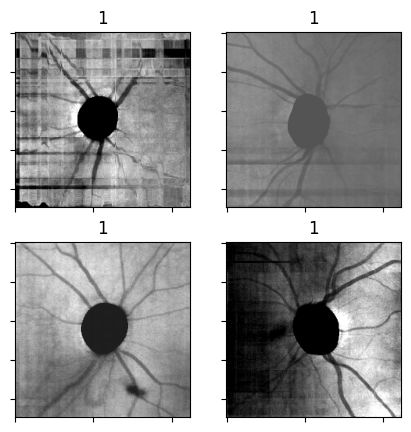

In [103]:
# show some images
fig = plt.figure(figsize=(5, 5))
for i in range(4):
	img, label = dataset[i]
	ax = fig.add_subplot(2, 2, i+1)
	ax.imshow(img.permute(1, 2, 0).numpy())
	ax.set_xticklabels([])
	ax.set_yticklabels([])
	ax.set_title(label)

# save image
plt.savefig('plots/data.png', dpi=300)

In [105]:
# load pretrained resent models
from torchvision.models import resnet18, resnet34, resnet50, resnet101, resnet152

# create custom resnet model
class ResNet(nn.Module):
	def __init__(self, model_name):
		super(ResNet, self).__init__()
		if model_name == 'resnet18':
			self.model = resnet18(weights="IMAGENET1K_V1")
		elif model_name == 'resnet34':
			self.model = resnet34(weights="IMAGENET1K_V1")
		elif model_name == 'resnet50':
			self.model = resnet50(weights="IMAGENET1K_V1")
		elif model_name == 'resnet101':
			self.model = resnet101(weights="IMAGENET1K_V1")
		elif model_name == 'resnet152':
			self.model = resnet152(weights="IMAGENET1K_V1")
		else:
			raise Exception('Invalid model name')

		# change the last layer
		self.model.fc = nn.Linear(self.model.fc.in_features, 1)
		self.model.sigmoid = nn.Sigmoid()

	def forward(self, x):
		x = self.model(x)
		return self.model.sigmoid(x)

In [106]:
# split data into train and test
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

In [107]:
# perform 5 fold cross validation
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# create 5 folds
skf = KFold(n_splits=5, shuffle=True, random_state=0)
folds = list(skf.split(np.arange(len(test_data))))

In [108]:
# create model
model = ResNet('resnet18')

# define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [109]:
# train model

train_loss_list = []
train_acc_list = []
train_precision_list = []
train_recall_list = []
train_f1_list = []

val_loss_list = []
val_acc_list = []
val_precision_list = []
val_recall_list = []
val_f1_list = []

best_loss = np.inf

num_epochs = 3

# perform 5 fold cross validation
for train_idx, val_idx in folds:
	# create dataloaders
	train_loader = DataLoader(torch.utils.data.Subset(train_data, train_idx), batch_size=32, shuffle=True)
	val_loader = DataLoader(torch.utils.data.Subset(train_data, val_idx), batch_size=32, shuffle=False)

	# train model
	for epoch in range(num_epochs):
		# train
		model.train()
		train_loss = 0
		train_acc = 0
		train_precision = 0
		train_recall = 0
		train_f1 = 0
		for img, label in train_loader:
			img = img.to(device)
			label = label.to(device)

			# forward pass
			output = model(img)
			loss = criterion(output, label.float().unsqueeze(1))

			# backward pass
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			# calculate metrics
			train_loss += loss.item()
			train_acc += accuracy_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int))
			train_precision += precision_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int))
			train_recall += recall_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int))
			train_f1 += f1_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int))

		# calculate average metrics
		train_loss /= len(train_loader)
		train_acc /= len(train_loader)
		train_precision /= len(train_loader)
		train_recall /= len(train_loader)
		train_f1 /= len(train_loader)

		# validation
		model.eval()
		val_loss = 0
		val_acc = 0
		val_precision = 0
		val_recall = 0
		val_f1 = 0
		for img, label in val_loader:
			img = img.to(device)
			label = label.to(device)

			# forward pass
			output = model(img)
			loss = criterion(output, label.float().unsqueeze(1))

			# calculate metrics
			val_loss += loss.item()
			val_acc += accuracy_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int))
			val_precision += precision_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int))
			val_recall += recall_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int))
			val_f1 += f1_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int))

		# calculate average metrics
		val_loss /= len(val_loader)
		val_acc /= len(val_loader)
		val_precision /= len(val_loader)
		val_recall /= len(val_loader)
		val_f1 /= len(val_loader)

		# print metrics
		print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}')

		# save metrics
		train_loss_list.append(train_loss)
		train_acc_list.append(train_acc)
		train_precision_list.append(train_precision)
		train_recall_list.append(train_recall)
		train_f1_list.append(train_f1)

		val_loss_list.append(val_loss)
		val_acc_list.append(val_acc)
		val_precision_list.append(val_precision)
		val_recall_list.append(val_recall)
		val_f1_list.append(val_f1)

		# save model
		if val_loss < best_loss:
			best_loss = val_loss
			torch.save(model.state_dict(), 'model.pt')



Epoch: 1/3, Train Loss: 0.7327, Train Acc: 0.4615, Train Precision: 0.7500, Train Recall: 0.1875, Train F1: 0.3000, Val Loss: 0.2119, Val Acc: 1.0000, Val Precision: 1.0000, Val Recall: 1.0000, Val F1: 1.0000
Epoch: 2/3, Train Loss: 0.3479, Train Acc: 0.8462, Train Precision: 1.0000, Train Recall: 0.7500, Train F1: 0.8571, Val Loss: 0.9636, Val Acc: 0.2857, Val Precision: 0.2857, Val Recall: 1.0000, Val F1: 0.4444
Epoch: 3/3, Train Loss: 0.1560, Train Acc: 0.9615, Train Precision: 0.9412, Train Recall: 1.0000, Train F1: 0.9697, Val Loss: 1.2321, Val Acc: 0.5714, Val Precision: 0.4000, Val Recall: 1.0000, Val F1: 0.5714
Epoch: 1/3, Train Loss: 0.4913, Train Acc: 0.8846, Train Precision: 0.8235, Train Recall: 1.0000, Train F1: 0.9032, Val Loss: 0.3796, Val Acc: 0.7143, Val Precision: 1.0000, Val Recall: 0.5000, Val F1: 0.6667
Epoch: 2/3, Train Loss: 0.0917, Train Acc: 0.9615, Train Precision: 0.9333, Train Recall: 1.0000, Train F1: 0.9655, Val Loss: 0.4489, Val Acc: 0.7143, Val Precision

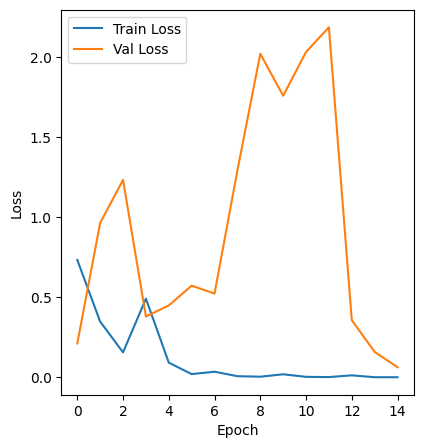

In [110]:
# plot metrics
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(train_loss_list, label='Train Loss')
ax.plot(val_loss_list, label='Val Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

In [111]:
# evaluate model
model.load_state_dict(torch.load('model.pt'))
model.eval()

test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

test_loss = 0
test_acc = 0
test_precision = 0
test_recall = 0
test_f1 = 0

for img, label in test_loader:
	img = img.to(device)
	label = label.to(device)

	# forward pass
	output = model(img)
	loss = criterion(output, label.float().unsqueeze(1))

	# calculate metrics
	test_loss += loss.item()
	test_acc += accuracy_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int))
	test_precision += precision_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int))
	test_recall += recall_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int))
	test_f1 += f1_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int))

# calculate average metrics
test_loss /= len(test_loader)
test_acc /= len(test_loader)
test_precision /= len(test_loader)
test_recall /= len(test_loader)
test_f1 /= len(test_loader)

# print metrics
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}')

Test Loss: 3.1567, Test Acc: 0.7969, Test Precision: 0.7778, Test Recall: 0.9688, Test F1: 0.8488


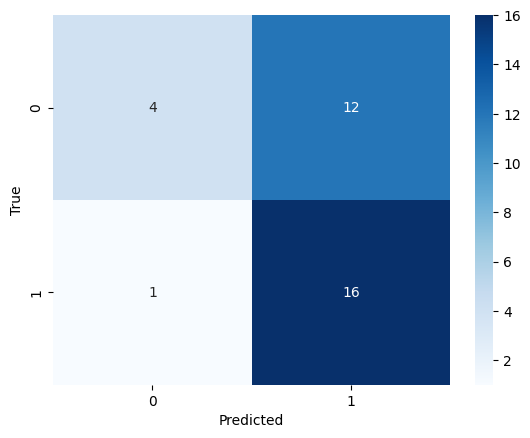

In [119]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

for img, label in test_loader:
	img = img.to(device)
	label = label.to(device)

	# forward pass
	output = model(img)

	# calculate metrics
	y_true.extend(label.cpu().numpy())
	y_pred.extend((output.cpu().detach().numpy() > 0.5).astype(int))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('plots/confusion_matrix.png', dpi=300)


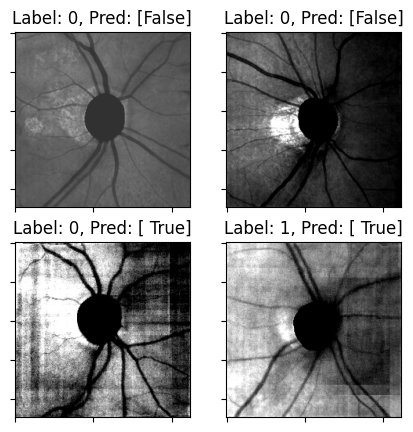

In [126]:
# show some images and predictions
dataiter = iter(test_loader)
img, label = next(dataiter)
img = img.to(device)
label = label.to(device)
output = model(img)

fig = plt.figure(figsize=(5, 5))
for i in range(4):
	ax = fig.add_subplot(2, 2, i+1)
	ax.imshow(img[i].permute(1, 2, 0).cpu().numpy())
	ax.set_xticklabels([])
	ax.set_yticklabels([])
	ax.set_title(f'Label: {label[i].cpu().numpy()}, Pred: {output[i].cpu().detach().numpy() > 0.5}')